In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

In [4]:
np.random.seed(42)

In [5]:
historical_data = pd.read_csv('historical_data.csv')

In [6]:
store_id_unique = historical_data["store_id"].unique().tolist()
store_id_and_category = {store_id: historical_data[historical_data.store_id == store_id].store_primary_category.mode() 
                         for store_id in store_id_unique}

In [7]:
def fill(store_id):
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

In [8]:
# fill null values
historical_data["clean_store_primary_category"] = historical_data.store_id.apply(fill)

In [50]:
## note that the number of non-null store_id values is less than the number of non-null 
# store_primary category values. We can probably fill in most of the missing values via inference

## there are also stores with multiple store_primary_category values. Such stores might be 'ghost kitchens',
# and need to be backfilled appropriately
# TODO #1 write function to downfill NaN store_primary_category values

def fillNulls_store_category(historical_data:pd.DataFrame) -> pd.DataFrame:
    store_id_list = historical_data['store_id'].unique().tolist()
    store_id_cat = {store_id: historical_data[historical_data.store_id == store_id].store_primary_category.mode() for store_id in store_id_list}
    historical_data['clean_store_primary_category']
    try:
        for x in store_id_list:
            historical_data['clean_store_primary_category'] = historical_data.store_id.apply(store_id_cat.values[0])
    except Exception as ee:
        raise ee
    return historical_data


In [9]:
## update types
## create target variable
def addFeatures_durations(historical_data:pd.DataFrame) -> pd.DataFrame:
    try:
        historical_data['created_at'] = pd.to_datetime(historical_data['created_at'])
        historical_data['actual_delivery_time'] = pd.to_datetime(historical_data['actual_delivery_time'])
        ## calculate delivery duration
        historical_data['actual_total_delivery_duration'] = (historical_data['actual_delivery_time'] - historical_data['created_at']).dt.total_seconds()
        ## estimated time spent outside the store/not on order preparation
        historical_data['est_time_non-prep'] = historical_data['estimated_order_place_duration'] + historical_data['estimated_store_to_consumer_driving_duration']
        ## estimated time spent in the store/not driving
        historical_data['est_time_prep'] = historical_data['actual_total_delivery_duration'] - historical_data['est_time_non-prep']
    except Exception as ex:
        raise ex
    return historical_data

In [10]:
## add ratio features
def addFeatures_ratios(historical_data:pd.DataFrame) -> pd.DataFrame:
    try:
        historical_data['busy_to_onshift'] = historical_data['total_busy_dashers'] / historical_data['total_onshift_dashers']
        historical_data['busy_to_outstanding'] = historical_data['total_busy_dashers'] / historical_data['total_outstanding_orders']
        historical_data['dasher_total_to_outstanding'] = historical_data['total_outstanding_orders'] / historical_data['total_busy_dashers']
        # replace infinite values with NaN to be dropped in the final cleaning step
        historical_data['busy_to_onshift'].replace([np.inf,-np.inf],np.nan,inplace=True)
        historical_data['busy_to_outstanding'].replace([np.inf,-np.inf],np.nan,inplace=True)
        historical_data['dasher_total_to_outstanding'].replace([np.inf,-np.inf],np.nan,inplace=True)
    except Exception as ex:
        raise ex
    return historical_data

In [11]:
## add dummies for categories
def addFeatures_dummies(historical_data:pd.DataFrame,dummy_column:str) -> pd.DataFrame:
    try:
        dumm = pd.get_dummies(historical_data[dummy_column],prefix=str(dummy_column + '_'),dtype=float)
        # concat dummies
        historical_data = pd.concat([historical_data,dumm],axis=1)
        historical_data = historical_data.drop(columns=[dummy_column])
    except Exception as ex:
        raise ex
    return historical_data

In [12]:
## build the training dataset using the functions above
train_df = addFeatures_durations(historical_data=historical_data)
train_df = addFeatures_ratios(historical_data=train_df)
## add dummy columns for clean_store_primary_category, market_id, order_protocol
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='clean_store_primary_category')
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='market_id')
train_df = addFeatures_dummies(historical_data=train_df,dummy_column='order_protocol')

In [13]:
# drop the native 'store_primary_category' column and all remaining non-feature columns, then do a headcheck
train_df.drop(columns=['store_primary_category','created_at','actual_delivery_time','store_id'],inplace=True)
## drop NaN's
train_df.dropna(inplace=True)
train_df = train_df.astype("float32")

train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,market_id__4.0,market_id__5.0,market_id__6.0,order_protocol__1.0,order_protocol__2.0,order_protocol__3.0,order_protocol__4.0,order_protocol__5.0,order_protocol__6.0,order_protocol__7.0
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,5000.0,3.0,1500.0,1900.0,2.0,2.0,2.0,446.0,338.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
## identify feature pairs with high correlation
def labelMaker_feature_pairs(train_df:pd.DataFrame) -> set:
    try:
        labeled_pairs = set()
        clmn = train_df.columns
        for i in range(0,train_df.shape[1]):
            for j in range(0,i+1):
                labeled_pairs.add((clmn[i],clmn[j]))
    except Exception as ex:
        raise ex
    return labeled_pairs

def calcAbsCorr_top_feature_pairs(train_df:pd.DataFrame,n:int) -> list:
    try:
        abs_corr = train_df.corr(method='pearson').abs().unstack()
        drop_labels = labelMaker_feature_pairs(train_df)
        abs_corr = abs_corr.drop(labels=drop_labels).sort_values(ascending=False)
    except Exception as ex:
        raise ex
    return abs_corr[0:n]

In [117]:
calcAbsCorr_top_feature_pairs(train_df=train_df,n=20)

actual_total_delivery_duration                est_time_prep                  0.985830
total_onshift_dashers                         total_busy_dashers             0.941300
                                              total_outstanding_orders       0.934254
total_busy_dashers                            total_outstanding_orders       0.930907
estimated_store_to_consumer_driving_duration  est_time_non-prep              0.923236
estimated_order_place_duration                order_protocol__1.0            0.897732
total_items                                   num_distinct_items             0.757986
subtotal                                      num_distinct_items             0.683367
busy_to_outstanding                           dasher_total_to_outstanding    0.609299
total_items                                   subtotal                       0.557399
min_item_price                                max_item_price                 0.540671
subtotal                                      max_item

In [15]:
## check for multicollinearity

def calcVIF(feature_frame:pd.DataFrame,target_feature:str):
    try:
        feature_frame = add_constant(feature_frame)
        feature_list = feature_frame.drop(columns=[target_feature]).columns.to_list()
        vif_frame = pd.DataFrame()
        vif_frame['feature'] = feature_list
        vif_frame['VIF'] = [variance_inflation_factor(feature_frame[feature_list].values,i) for i in range(len(feature_list))]
    except Exception as ex:
        raise ex
    return vif_frame.sort_values(by=['VIF'],ascending=False).reset_index(drop=True)

def removeFeature_VIF(feature_frame:pd.DataFrame,target_feature:str,vif_limit:int):
    vif_table = calcVIF(feature_frame=feature_frame,target_feature=target_feature)
    try:
        ## drop nan columns from feature set, nan VIF values from base VIF table
        vif_table['VIF'].replace(to_replace=[np.inf,-np.inf],value=np.nan,inplace=True)
        nan_list = vif_table[vif_table['VIF'].isnull()]['feature'].to_list()
        feature_frame = feature_frame.drop(columns=nan_list)
        vif_table = vif_table.set_index(vif_table.feature)
        vif_table = vif_table.drop(labels=nan_list).reset_index(drop=True)
        ## start
        multicollinearity = True if vif_table['VIF'].values.tolist()[1] > vif_limit else False
        while multicollinearity:
            lead_vif_feature = vif_table['feature'].values.tolist()[1]
            feature_frame = feature_frame.drop(columns=lead_vif_feature)
            vif_table = calcVIF(feature_frame=feature_frame,target_feature=target_feature)
            multicollinearity = True if vif_table['VIF'].values.tolist()[1] > vif_limit else False
    except Exception as ex:
        raise ex
    return feature_frame,vif_table

In [98]:
trim_train_df,vif_features = removeFeature_VIF(feature_frame=train_df,target_feature='actual_total_delivery_duration',vif_limit=20)

c:\Users\lukew\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\Users\lukew\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\Users\lukew\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
c:\Users\lukew\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [28]:
## feature selection/dimensionality reduction with PCA
##TODO #2 make a class for PCA
##TODO #3 retain row numbers in scaler --DONE

def build_train_test(dataset:pd.DataFrame,target_feature:str,test_size:int):
    try:
        X = dataset.drop(columns=target_feature)
        y = dataset[target_feature]
        x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=42)
        x_train,x_test = pd.DataFrame(x_train),pd.DataFrame(x_test)
    except Exception as ex:
        raise ex
    return x_train,x_test,y_train,y_test

def apply_standard_scaler(dataset):
#applies the standard scaler to a single dataset
    scaler = StandardScaler()
    try:
        if type(dataset) == pd.DataFrame:
            scaler.fit(dataset.values)
            dataset_scaled = scaler.transform(dataset.values)
            dataset_scaled = pd.DataFrame(dataset_scaled,index=dataset.index,columns=dataset.columns)
        else:
            scaler.fit(dataset)
            dataset_scaled = scaler.transform(dataset)
            test_stdScale = scaler.transform(dataset)
    except Exception as ex:
        raise ex
    return dataset_scaled

In [32]:
x_train,x_test,y_train,y_test = build_train_test(dataset=train_df,target_feature='actual_total_delivery_duration',test_size=0.3)
x_train_stdScale,x_test_stdScale = apply_standard_scaler(train=x_train,test=x_test)

In [ ]:
def PCAcalc_expl_var(dataset,target_expl_variance:int):
## returns the number of components required to explain the target_expl_variance
    pca = PCA()
    try:
        pca = pca.fit(dataset)
        

In [53]:
pca = PCA()
pca.fit(x_train_stdScale)
x_train_pca,x_test_pca = pca.transform(x_train_stdScale),pca.transform(x_test_stdScale)

In [79]:
exp_var = pd.DataFrame(data=pca.explained_variance_ratio_.T,index=x_train_stdScale.columns,columns=['exp_var'])
exp_var = exp_var.sort_values(by=['exp_var'],ascending=False)
## exp_var['run_sum'] = np.cumsum(exp_var['exp_var'])
exp_var

,exp_var
total_items,4.172818e-02
subtotal,2.777269e-02
num_distinct_items,2.666235e-02
min_item_price,2.058501e-02
max_item_price,1.862902e-02
...,...
order_protocol__3.0,3.457178e-05
order_protocol__4.0,2.386228e-15
order_protocol__5.0,4.250911e-17
order_protocol__6.0,3.192477e-18


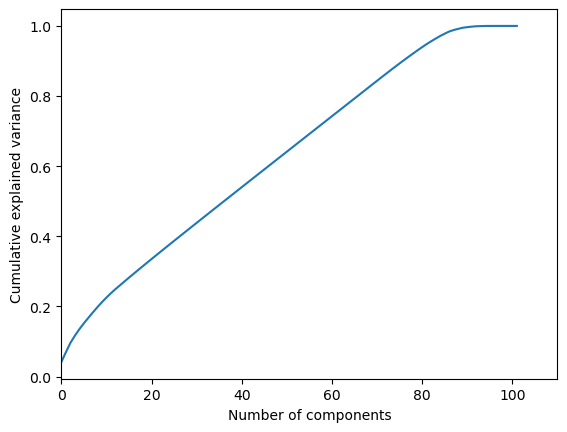

In [67]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,110,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()